In [6]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import dlib
import scipy
import cv2
import mediapipe as mp
from scipy.optimize import fsolve
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
nx = ny = 512

X, Y = np.meshgrid( np.arange(nx, dtype=np.float32), np.arange(ny, dtype=np.float32) )

In [7]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [8]:
nose_front_pts = np.array([4, 5, 6, 168, 195, 197])
nose_base_pts = np.array([1, 2, 19, 94])
nose_base_pts = np.array([2, 19, 20, 60, 94, 97, 99, 125, 141, 238, 241, 242, 250, 290, 326, 328, 354, 370, 458, 461, 462])

lips_pts = np.array([61,146,91,181,84,17,314,405,321,375,291,308,324,318,402,317,14,87,178,88,95,78,\
    61,185,40,39,37,0,267,269,270,409,291,308,415,310,311,312,13,82,81,80,191,78,])
lower_lip_pts = np.array([61,146,91,181,84,17,314,405,321,375,291,308,324,318,402,317,14,87,178,88,95,78])
upper_lip_pts = np.array([61,185,40,39,37,0,267,269,270,409,291,308,415,310,311,312,13,82,81,80,191,78,])
inner_lips_left_pt = 78
inner_lips_right_pt = 308
outer_lips_left_pt = 61
outer_lips_right_pt = 291

top_upper_lip_pts = np.array([61, 185,  40,  39,  37,   0, 267, 269, 270, 409, 291])
bottom_upper_lip_pts = np.array([78, 415, 310, 311, 312,  13,  82,  81,  80, 191, 308])
top_lower_lip_pts = np.array([ 146,  91, 181,  84,  17, 314, 405, 321, 375])
bottom_lower_lip_pts = np.array([324, 318, 402, 317,  14,  87, 178,  88,  95])

inner_lips_pts = np.array([78, 415, 310, 311, 312,  13,  82,  81,  80, 191, 308, 324, 318, 402, 317,  14,  87, 178,  88,  95])
outer_lips_pts = np.array([61, 185,  40,  39,  37,   0, 267, 269, 270, 409, 291, 146,  91, 181,  84,  17, 314, 405, 321, 375])

not_lips_pts = np.setdiff1d(np.arange(478),lips_pts)

contour_pts = np.array([ 10, 109,  67, 103,  54,  21, 162, 127, 234,  93, 132,  58, 172,
       136, 150, 149, 176, 148, 152, 377, 400, 378, 379, 365, 397, 288,
       361, 323, 454, 356, 389, 251, 284, 332, 297, 338])

nose_pts = np.array(
    [    1,   2,   3,   4,   5,   6,  19,  20,  44,  45,  48,  49,  51,
        59,  60,  64,  75,  79,  94,  97,  98,  99, 102, 114, 115, 122,
       125, 128, 129, 131, 134, 141, 166, 168, 174, 188, 193, 195, 196,
       197, 198, 203, 217, 218, 219, 220, 235, 236, 237, 238, 239, 240,
       241, 242, 244, 245, 248, 250, 274, 275, 278, 279, 281, 289, 290,
       294, 305, 309, 326, 327, 328, 331, 343, 344, 351, 354, 357, 358,
       360, 363, 370, 392, 399, 412, 417, 419, 420, 423, 437, 438, 439,
       440, 455, 456, 457, 458, 459, 460, 461, 462, 464, 465]
)

nose_pts_no_center = np.array(
    [    1,   2,   3,   5,   6,  19,  20,  44,  45,  48,  49,  51,
        59,  60,  64,  75,  79,  94,  97,  98,  99, 102, 114, 115, 122,
       125, 128, 129, 131, 134, 141, 166, 168, 174, 188, 193, 195, 196,
       197, 198, 203, 217, 218, 219, 220, 235, 236, 237, 238, 239, 240,
       241, 242, 244, 245, 248, 250, 274, 275, 278, 279, 281, 289, 290,
       294, 305, 309, 326, 327, 328, 331, 343, 344, 351, 354, 357, 358,
       360, 363, 370, 392, 399, 412, 417, 419, 420, 423, 437, 438, 439,
       440, 455, 456, 457, 458, 459, 460, 461, 462, 464, 465]
)

not_nose_pts = np.setdiff1d(np.arange(478),nose_pts)

nose_left_pt = 102
nose_right_pt = 331
nose_center_pt = 4

eye_left_left_pt = 33
eye_left_right_pt = 133
eye_left_up_pt = 159
eye_left_down_pt = 144

eye_right_left_pt = 362
eye_right_right_pt = 263
eye_right_up_pt = 386
eye_right_down_pt = 373


under_eyes_right_pts = np.array([451, 450, 449, 448])
under_eyes_left_pts = np.array([231, 230, 229, 228])
under_eyes_right_pts_bis = np.array([346, 347, 348])
under_eyes_left_pts_bis = np.array([117, 118, 119])

In [9]:
def face_keypoints(image):
    global face_mesh
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0]
    data = []
    for pt in face_landmarks.landmark:
        data.append([pt.x, pt.y, pt.z])
    data = np.array(data)
    return data

data.shape = (478, 3)


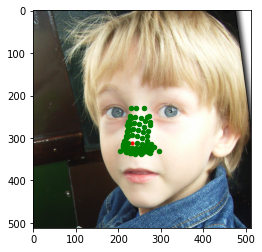

data.shape = (478, 3)


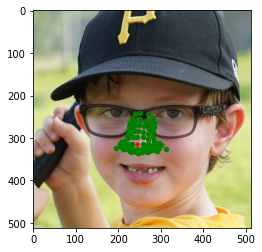

In [10]:
foldername = "CeterisParibusDataset"
# foldername = "test"
IMAGE_FILES = [foldername+'/'+filename for filename in os.listdir(foldername) if 'png' in filename or 'jpg' in filename]

face_mesh =  mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5)

for filename in IMAGE_FILES[:2]:
    image = cv2.imread(filename)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0]
    data = []
    for pt in face_landmarks.landmark:
        data.append([pt.x, pt.y, pt.z])
    data = np.array(data)
    
    plt.imshow(image[:,:,::-1])
    print(f"data.shape = {data.shape}")
    
    x_nose = data[nose_pts, 0]
    y_nose = data[nose_pts, 1]
    
    x_nose_center = data[nose_center_pt, 0]
    y_nose_center = data[nose_center_pt, 1]
    
    plt.scatter(x_nose_center*512, y_nose_center*512, s=10, color='red')
    plt.scatter(data[nose_pts_no_center, 0]*512, data[nose_pts_no_center, 1]*512, s=20, color='green')

    plt.show()


## Darken area under eyes

In [11]:
def bag_under_eyes(image):
    #factors
    f = 150
    mu = 10
    # keypoints
    data = face_keypoints(image)
    eye_left_left = data[eye_left_left_pt, :2]
    eye_left_right = data[eye_left_right_pt, :2]
    eye_left_up = data[eye_left_up_pt, :2]
    eye_left_down = data[eye_left_down_pt, :2]
    eye_right_left = data[eye_right_left_pt, :2]
    eye_right_right = data[eye_right_right_pt, :2]
    eye_right_up = data[eye_right_up_pt, :2]
    eye_right_down = data[eye_right_down_pt, :2]
    under_eyes_right = data[under_eyes_right_pts, :2]
    under_eyes_left = data[under_eyes_left_pts, :2]
    under_eyes_right_bis = data[under_eyes_right_pts_bis, :2]
    under_eyes_left_bis = data[under_eyes_left_pts_bis, :2]
    eye_left_center = np.mean(np.array([eye_left_left, eye_left_right, eye_left_up, eye_left_down]), axis=0)
    eye_right_center = np.mean(np.array([eye_right_left, eye_right_right, eye_right_up, eye_right_down]), axis=0)
    d_under_eyes_right_bis = -under_eyes_right_bis+eye_right_center
    d_under_eyes_left_bis = -under_eyes_left_bis+eye_right_center
    d_under_eyes_right = under_eyes_right-eye_right_center
    d_under_eyes_left = under_eyes_left-eye_left_center
    contour = data[contour_pts, :2]
    d_contour = np.zeros( (contour.shape[0],2) )
    added_contour_pts = np.array([22,23,24,110, 252,253,254,339, 50,36,280,266, 296,334,66,105,9,8,168,6])
    added_contour = data[added_contour_pts, :2]
    d_added_contour = np.zeros( (added_contour.shape[0],2) )
    border = np.array( [[0,0,], [1,0,], [0,1,], [1,1,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [under_eyes_right, under_eyes_left, under_eyes_right_bis, under_eyes_left_bis, contour, added_contour, border] )*511).astype(np.int32)
    d_keys = np.vstack( [d_under_eyes_right, d_under_eyes_left, d_under_eyes_right_bis, d_under_eyes_left_bis, d_contour, d_added_contour, d_border] )
    # image remap
    d_keys_y = f*d_keys[:,1]
    dy = np.zeros( (512,512) )
    dy[keys[:,1], keys[:,0]] = d_keys_y
    dy = gaussian_filter(dy, mu).astype(np.float32)*512
    new_img = cv2.remap(image, X, Y-dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    mask = dy>5
    a,b = np.where(mask)
    a += (1.8*dy[a,b]).astype(np.int64)
    darken = np.zeros_like(new_img)
    darken[a,b,:]=150
    darken = gaussian_filter(darken, 8).astype(new_img.dtype)
    new_img -= darken
    new_img.clip(0,255)
    return new_img


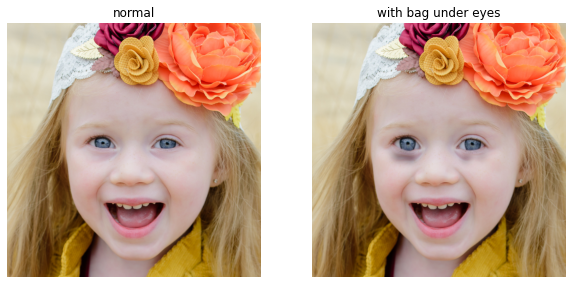

In [12]:
i = 5
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(10, 5), facecolor='white')
ax = f.add_subplot(1,2,1)
ax.imshow(image[:,:,::-1])
ax.set_title('normal')
ax.axis('off')

ax = f.add_subplot(1,2,2)
new_img = bag_under_eyes(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('with bag under eyes')
ax.axis('off')
f.savefig('bag_under_eyes.png', bbox_inches='tight')

## Continuous Deformations

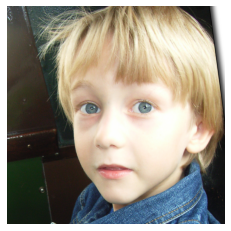

In [13]:
i = 0
filename = IMAGE_FILES[i]
image = cv2.imread(filename)
data = face_keypoints(image)

plt.imshow(image[:,:,::-1], vmin=-10, vmax=10)
plt.axis('off')
plt.show()

In [14]:
nose = data[nose_pts, :2]
nose_center = data[nose_center_pt, :2]
d_nose = ((nose-nose_center)*512)

not_nose = data[not_nose_pts, :2]
d_not_nose = np.zeros( (not_nose.shape[0],2) )

border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
d_border = np.zeros( border.shape )

keys = np.vstack( [nose, not_nose, border] )
d_keys = np.vstack( [d_nose, d_not_nose, d_border] )

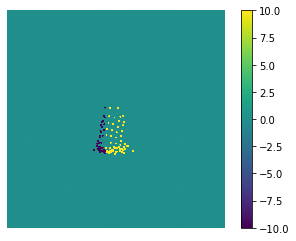

In [15]:
# keypoints moves in x direction
dx = np.zeros( (512,512) )
dx[(nose[:,1]*512).astype(np.int32), (nose[:,0]*512).astype(np.int32)] = d_nose[:,0]*512
stage1 = dx.copy()
plt.imshow(dx, vmin=-10, vmax=10)
plt.colorbar()
plt.axis('off')
plt.show()

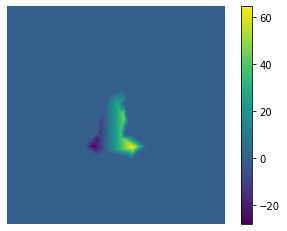

In [16]:
# using griddata to get values outside keypoints
dx = griddata(((keys[:,1]*512).astype(np.int32), (keys[:,0]*512).astype(np.int32)), d_keys[:,0], (Y, X))
plt.imshow(dx)
plt.colorbar()
plt.axis('off')
plt.show()

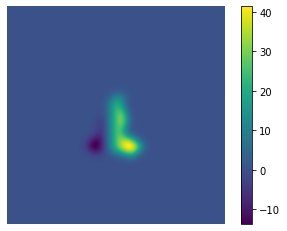

In [17]:
#blur to smooth the deformation
dx = gaussian_filter(dx, 10).astype(np.float32)
plt.imshow(dx)
plt.colorbar()
plt.axis('off')
plt.show()

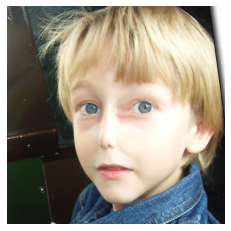

In [18]:
#show result
new_img = cv2.remap(image, X+dx, Y, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
plt.imshow(new_img[:,:,::-1])
plt.axis('off')
plt.show()

In [19]:
image.shape

(512, 512, 3)

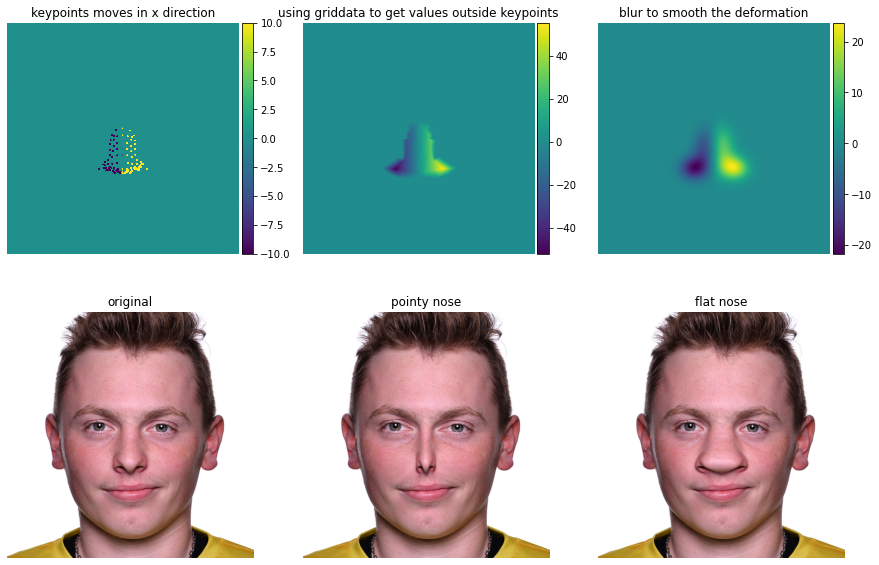

In [132]:
# load image
i = 8
filename = IMAGE_FILES[i]
image = cv2.imread(filename)
data = face_keypoints(image)

# calculate keypoints
nose = data[nose_pts, :2]
nose_center = data[nose_center_pt, :2]
d_nose = ((nose-nose_center)*512)
not_nose = data[not_nose_pts, :2]
d_not_nose = np.zeros( (not_nose.shape[0],2) )
border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
d_border = np.zeros( border.shape )
keys = np.vstack( [nose, not_nose, border] )
d_keys = np.vstack( [d_nose, d_not_nose, d_border] )

# keypoints moves in x direction
dx = np.zeros( (512,512) )
dx[(nose[:,1]*512).astype(np.int32), (nose[:,0]*512).astype(np.int32)] = d_nose[:,0]*512
stage1 = dx.copy()
# using griddata to get values outside keypoints
dx = griddata(((keys[:,1]*512).astype(np.int32), (keys[:,0]*512).astype(np.int32)), d_keys[:,0], (Y, X))
stage2 = dx.copy()
# blur to smooth the deformation
dx = gaussian_filter(dx, 15).astype(np.float32)
stage3 = dx.copy()

# result
new_img = cv2.remap(image, X+dx, Y, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
new_img_bis = cv2.remap(image, X-dx, Y, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)


# PLOT
f = plt.figure(figsize=(15, 10), facecolor='white')
ax = f.add_subplot(2,3,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(stage1, vmin=-10, vmax=10)
f.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('keypoints moves in x direction')
ax.axis('off')

ax = f.add_subplot(2,3,2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(stage2)
f.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('using griddata to get values outside keypoints')
ax.axis('off')

ax = f.add_subplot(2,3,3)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(stage3)
f.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('blur to smooth the deformation')
ax.axis('off')

ax = f.add_subplot(2,3,4)
ax.imshow(image[:,:,::-1])
ax.set_title('original')
ax.axis('off')

ax = f.add_subplot(2,3,5)
ax.imshow(new_img[:,:,::-1])
ax.set_title('pointy nose')
ax.axis('off')

ax = f.add_subplot(2,3,6)
ax.imshow(new_img_bis[:,:,::-1])
ax.set_title('flat nose')
ax.axis('off')
f.savefig('deformation_expl.png', bbox_inches='tight')
plt.show()

In [133]:
def pointy_nose(image, return_dx=False, return_dy=False):
    # keypoints
    data = face_keypoints(image)
    nose = data[nose_pts, :2]
    nose_center = data[nose_center_pt, :2]
    d_nose = ((nose-nose_center)*512)
    not_nose = data[not_nose_pts, :2]
    d_not_nose = np.zeros( (not_nose.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [nose, not_nose, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_nose, d_not_nose, d_border] )
    # image remap
    m = d_keys[:,0]!=0
    d_keys_x = d_keys[:,0].copy()
    d_keys_x[m] /= np.abs(d_keys[m,0])**0.1
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    m = d_keys[:,1]!=0
    d_keys_y = d_keys[:,1].copy()
    d_keys_y[m] /= np.sqrt(np.abs(d_keys[m,1]))
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X+dx, Y-dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

In [134]:
def flat_nose(image):
    # keypoints
    data = face_keypoints(image)
    nose = data[nose_pts, :2]
    nose_center = data[nose_center_pt, :2]
    d_nose = ((nose-nose_center)*512)
    not_nose = data[not_nose_pts, :2]
    d_not_nose = np.zeros( (not_nose.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [nose, not_nose, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_nose, d_not_nose, d_border] )
    # image remap
    m = d_keys[:,0]!=0
    d_keys_x = d_keys[:,0].copy()
    d_keys_x[m] /= np.abs(d_keys[m,0])**0.1
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    m = d_keys[:,1]!=0
    d_keys_y = d_keys[:,1].copy()
    d_keys_y[m] /= np.sqrt(np.abs(d_keys[m,1]))
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X-dx, Y+dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

In [135]:
def small_nose(image):
    # keypoints
    data = face_keypoints(image)
    nose = data[nose_pts, :2]
    nose_center = data[nose_center_pt, :2]
    d_nose = ((nose-nose_center)*512)
    not_nose = data[not_nose_pts, :2]
    d_not_nose = np.zeros( (not_nose.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [nose, not_nose, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_nose, d_not_nose, d_border] )
    # image remap
    m = d_keys[:,0]!=0
    d_keys_x = d_keys[:,0].copy()
    d_keys_x[m] /= np.abs(d_keys[m,0])**0.25
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    m = d_keys[:,1]!=0
    d_keys_y = d_keys[:,1].copy()
    d_keys_y[m] /= np.sqrt(np.abs(d_keys[m,1]))
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X+dx, Y+dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

In [136]:
def big_nose(image):
    # keypoints
    data = face_keypoints(image)
    nose = data[nose_pts, :2]
    nose_center = data[nose_center_pt, :2]
    d_nose = ((nose-nose_center)*512)
    not_nose = data[not_nose_pts, :2]
    d_not_nose = np.zeros( (not_nose.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [nose, not_nose, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_nose, d_not_nose, d_border] )
    # image remap
    m = d_keys[:,0]!=0
    d_keys_x = d_keys[:,0].copy()
    d_keys_x[m] /= np.abs(d_keys[m,0])**0.25
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    m = d_keys[:,1]!=0
    d_keys_y = d_keys[:,1].copy()
    d_keys_y[m] /= np.sqrt(np.abs(d_keys[m,1]))
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X-dx, Y-dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

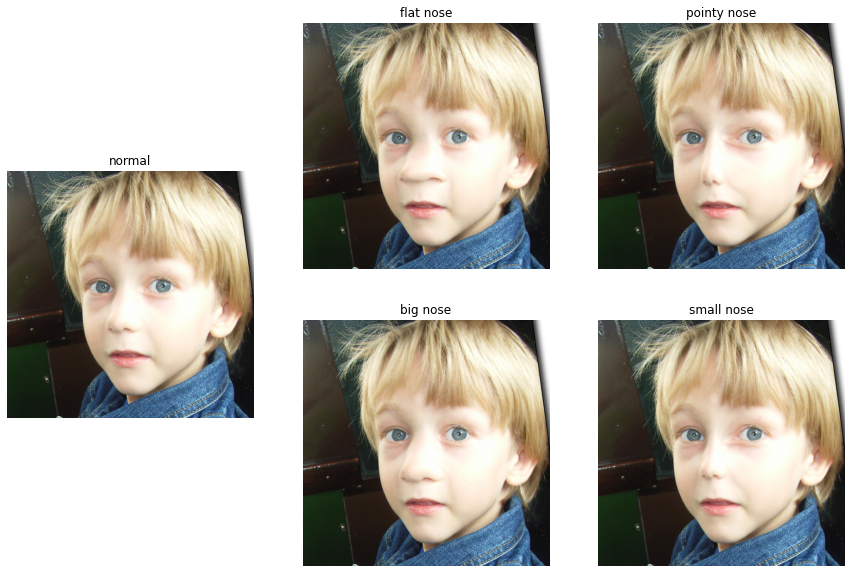

In [137]:
# load image
i = 0 
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(15, 10), facecolor='white')
ax = f.add_subplot(1,3,1)
ax.imshow(image[:,:,::-1])
ax.set_title('normal')
ax.axis('off')

ax = f.add_subplot(2,3,2)
new_img = flat_nose(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('flat nose')
ax.axis('off')

ax = f.add_subplot(2,3,3)
new_img = pointy_nose(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('pointy nose')
ax.axis('off')

ax = f.add_subplot(2,3,5)
new_img = big_nose(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('big nose')
ax.axis('off')

ax = f.add_subplot(2,3,6)
new_img = small_nose(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('small nose')
ax.axis('off')
f.savefig('nose_transfo.png', bbox_inches='tight')
plt.show()

In [138]:
def big_lips(image):
    #factor
    f = 1.1
    # keypoints
    data = face_keypoints(image)
    inner_lips = data[inner_lips_pts, :2]
    outer_lips  = data[outer_lips_pts, :2]
    lips  = data[lips_pts, :2]
    mouth_center = np.mean(lips, axis=0)
    d_inner_lips = ((inner_lips-mouth_center)*512)
    d_outer_lips = -((outer_lips-mouth_center)*512)
    not_lips = data[not_lips_pts, :2]
    d_not_lips = np.zeros( (not_lips.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [inner_lips, outer_lips, not_lips, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_inner_lips, d_outer_lips, d_not_lips, d_border] )

    # image remap
    d_keys_x = f*d_keys[:,0]
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    d_keys_y = f*d_keys[:,1]
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X+dx, Y+dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

In [139]:
def small_lips(image):
    #factor
    f = 1.5
    # keypoints
    data = face_keypoints(image)
    inner_lips = data[inner_lips_pts, :2]
    outer_lips  = data[outer_lips_pts, :2]
    lips  = data[lips_pts, :2]
    mouth_center = np.mean(lips, axis=0)
    d_inner_lips = ((inner_lips-mouth_center)*512)
    d_outer_lips = -((outer_lips-mouth_center)*512)
    not_lips = data[not_lips_pts, :2]
    d_not_lips = np.zeros( (not_lips.shape[0],2) )
    border = np.array( [[0,0,], [512,0,], [0,512,], [512,512,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [inner_lips, outer_lips, not_lips, border] )*512).astype(np.int32)
    d_keys = np.vstack( [d_inner_lips, d_outer_lips, d_not_lips, d_border] )

    # image remap
    d_keys_x = f*d_keys[:,0]
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = gaussian_filter(dx, 10).astype(np.float32)
    d_keys_y = f*d_keys[:,1]
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = gaussian_filter(dy, 10).astype(np.float32)
    new_img = cv2.remap(image, X-dx, Y-dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img

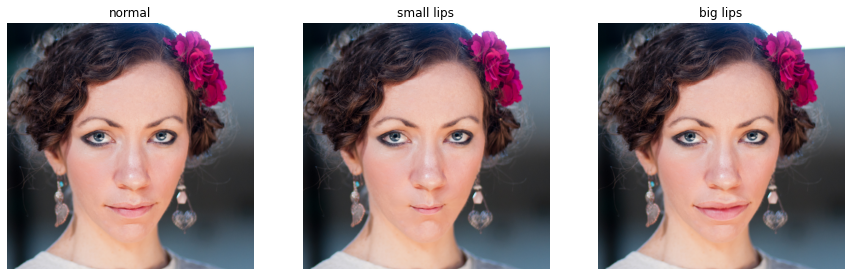

In [140]:
i = 13
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(15, 5), facecolor='white')
ax = f.add_subplot(1,3,1)
ax.imshow(image[:,:,::-1])
ax.set_title('normal')
ax.axis('off')

ax = f.add_subplot(1,3,2)
new_img = small_lips(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('small lips')
ax.axis('off')

ax = f.add_subplot(1,3,3)
new_img = big_lips(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('big lips')
ax.axis('off')

f.savefig('lips_transfo.png', bbox_inches='tight')
plt.show()

In [141]:
def narrow_eyes(image):
    #factors
    f = 5
    mu = 30
    # keypoints
    data = face_keypoints(image)
    eye_left_left = data[eye_left_left_pt, :2]
    eye_left_right = data[eye_left_right_pt, :2]
    eye_left_up = data[eye_left_up_pt, :2]
    eye_left_down = data[eye_left_down_pt, :2]
    eye_right_left = data[eye_right_left_pt, :2]
    eye_right_right = data[eye_right_right_pt, :2]
    eye_right_up = data[eye_right_up_pt, :2]
    eye_right_down = data[eye_right_down_pt, :2]
    eye_vertical = np.array([eye_left_down, eye_left_up, eye_right_down, eye_right_up])
    eye_horizontal = np.array([eye_left_left, eye_left_right, eye_right_left, eye_right_right])
    eye_left_center = np.mean(np.array([eye_left_left, eye_left_right, eye_left_up, eye_left_down]), axis=0)
    eye_right_center = np.mean(np.array([eye_right_left, eye_right_right, eye_right_up, eye_right_down]), axis=0)
    contour = data[contour_pts, :2]
    z = np.zeros(2)
    k = np.array( [eye_left_left, eye_left_right, eye_left_up, eye_left_down, \
                   eye_right_left, eye_right_right, eye_right_up, eye_right_down,\
                   eye_left_center, eye_right_center] )
    d_k =  np.array( [eye_left_left-eye_left_center, eye_left_right-eye_left_center, \
                      eye_left_center-eye_left_up, eye_left_center-eye_left_down, \
                      eye_right_left-eye_right_center, eye_right_right-eye_right_center, \
                      eye_right_center-eye_right_up, eye_right_center-eye_right_down,\
                      z, z] )*512
    contour = data[contour_pts, :2]
    d_contour = np.zeros( (contour.shape[0],2) )
    added_contour_pts = np.array([50,36,280,266, 296,334,66,105,9,8,168,6])
    added_contour = data[added_contour_pts, :2]
    d_added_contour = np.zeros( (added_contour.shape[0],2) )
    border = np.array( [[0,0,], [1,0,], [0,1,], [1,1,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [k, contour, added_contour, border] )*511).astype(np.int32)
    d_keys = np.vstack( [d_k, d_contour, d_added_contour, d_border] )
    # image remap
    d_keys_x = f*d_keys[:,0]
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = np.zeros( (512,512) )
    dx[keys[:,1], keys[:,0]] = d_keys_x
    dx = gaussian_filter(dx, mu).astype(np.float32)*512
    d_keys_y = f*d_keys[:,1]
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = np.zeros( (512,512) )
    dy[keys[:,1], keys[:,0]] = d_keys_y
    dy = gaussian_filter(dy, mu).astype(np.float32)*512
    new_img = cv2.remap(image, X-dx, Y-dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img


In [142]:

def round_eyes(image):
    #factors
    f = 5
    mu = 30
    # keypoints
    data = face_keypoints(image)
    eye_left_left = data[eye_left_left_pt, :2]
    eye_left_right = data[eye_left_right_pt, :2]
    eye_left_up = data[eye_left_up_pt, :2]
    eye_left_down = data[eye_left_down_pt, :2]
    eye_right_left = data[eye_right_left_pt, :2]
    eye_right_right = data[eye_right_right_pt, :2]
    eye_right_up = data[eye_right_up_pt, :2]
    eye_right_down = data[eye_right_down_pt, :2]
    eye_vertical = np.array([eye_left_down, eye_left_up, eye_right_down, eye_right_up])
    eye_horizontal = np.array([eye_left_left, eye_left_right, eye_right_left, eye_right_right])
    eye_left_center = np.mean(np.array([eye_left_left, eye_left_right, eye_left_up, eye_left_down]), axis=0)
    eye_right_center = np.mean(np.array([eye_right_left, eye_right_right, eye_right_up, eye_right_down]), axis=0)
    contour = data[contour_pts, :2]
    z = np.zeros(2)
    k = np.array( [eye_left_left, eye_left_right, eye_left_up, eye_left_down, \
                   eye_right_left, eye_right_right, eye_right_up, eye_right_down,\
                   eye_left_center, eye_right_center] )
    d_k =  np.array( [eye_left_left-eye_left_center, eye_left_right-eye_left_center, \
                      eye_left_center-eye_left_up, eye_left_center-eye_left_down, \
                      eye_right_left-eye_right_center, eye_right_right-eye_right_center, \
                      eye_right_center-eye_right_up, eye_right_center-eye_right_down,\
                      z, z] )*512
    contour = data[contour_pts, :2]
    d_contour = np.zeros( (contour.shape[0],2) )
    added_contour_pts = np.array([50,36,280,266, 296,334,66,105,9,8,168,6])
    added_contour = data[added_contour_pts, :2]
    d_added_contour = np.zeros( (added_contour.shape[0],2) )
    border = np.array( [[0,0,], [1,0,], [0,1,], [1,1,],] )
    d_border = np.zeros( border.shape )
    keys = (np.vstack( [k, contour, added_contour, border] )*511).astype(np.int32)
    d_keys = np.vstack( [d_k, d_contour, d_added_contour, d_border] )
    # image remap
    d_keys_x = f*d_keys[:,0]
    dx = griddata( (keys[:,1], keys[:,0]), d_keys_x, (Y, X))
    dx = np.zeros( (512,512) )
    dx[keys[:,1], keys[:,0]] = d_keys_x
    dx = gaussian_filter(dx, mu).astype(np.float32)*512
    d_keys_y = f*d_keys[:,1]
    dy = griddata( (keys[:,1], keys[:,0]), d_keys_y, (Y, X))
    dy = np.zeros( (512,512) )
    dy[keys[:,1], keys[:,0]] = d_keys_y
    dy = gaussian_filter(dy, mu).astype(np.float32)*512
    new_img = cv2.remap(image, X+dx, Y+dy, cv2.INTER_LINEAR, cv2.BORDER_REPLICATE)
    return new_img


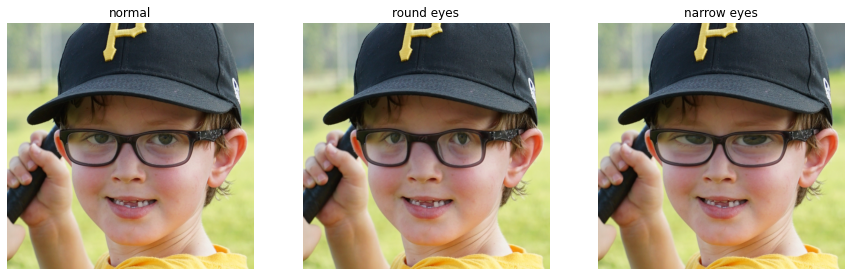

In [143]:
i=1
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(15, 5), facecolor='white')
ax = f.add_subplot(1,3,1)
ax.imshow(image[:,:,::-1])
ax.set_title('normal')
ax.axis('off')

ax = f.add_subplot(1,3,2)
new_img = round_eyes(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('round eyes')
ax.axis('off')

ax = f.add_subplot(1,3,3)
new_img = narrow_eyes(image)
ax.imshow(new_img[:,:,::-1])
ax.set_title('narrow eyes')
ax.axis('off')

f.savefig('eyes_transfo.png', bbox_inches='tight')
plt.show()

In [144]:
def skin_mask(image):
    skins = np.array([
        # [41,17,94],
        [28,37,90],
        # [29,41,92],
        # [29,41,92],
        # [29,45,72],
        [22,68,55],
        # [15,67,41],
        [19,31,31],
        ])
    #skin mask
    r = image[:,:,2]
    g = image[:,:,1]
    b = image[:,:,0]
    c1 = r > 95
    c2 = g > 40
    c3 = b > 20
    c4 = (np.max(image, axis=2) - np.min(image, axis=2)) > 15
    c4 = np.abs(r-g) > 15
    c5 = r > g
    c6 = r > b
    skin_mask = c1 & c2 & c3 & c4 & c5 & c6
    return skin_mask

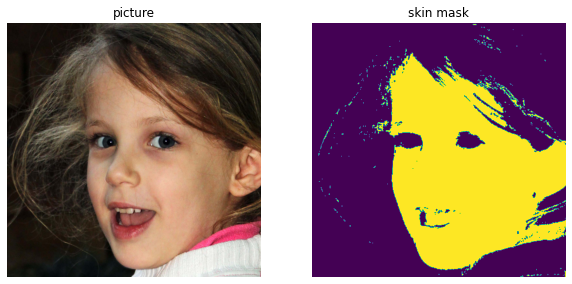

In [145]:
i = 4
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(10, 5), facecolor='white')
ax = f.add_subplot(1,2,1)
ax.imshow(image[:,:,::-1])
ax.set_title('picture')
ax.axis('off')

ax = f.add_subplot(1,2,2)
mask = skin_mask(image)
ax.imshow(mask)
ax.set_title('skin mask')
ax.axis('off')
f.savefig('skin_mask.png', bbox_inches='tight')

In [146]:
def change_skin_tone(image, target_skin_tone):
    skins = np.array([
        # [41,17,94],
        [28,37,90],
        # [29,41,92],
        # [29,41,92],
        # [29,45,72],
        [22,68,55],
        # [15,67,41],
        [19,31,31],
        ])
    target_skin_tone = max(0, min(skins.shape[0]-1, target_skin_tone))
    #skin mask
    r = image[:,:,2]
    g = image[:,:,1]
    b = image[:,:,0]
    c1 = r > 95
    c2 = g > 40
    c3 = b > 20
    c4 = (np.max(image, axis=2) - np.min(image, axis=2)) > 15
    c4 = np.abs(r-g) > 15
    c5 = r > g
    c6 = r > b
    skin_mask = c1 & c2 & c3 & c4 & c5 & c6
    #operation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    xs,ys = np.where(skin_mask)
    mean_skin = np.mean(hsv[xs,ys,:], axis=0)
    # print('mean:', mean_skin)
    matching_skin = np.argmin(np.linalg.norm(skins-mean_skin, axis=1))
    # print(matching_skin+1, '/', skins.shape[0])
    change = skins[target_skin_tone]-skins[matching_skin]
    hsv[xs,ys,1:] += change[1:].astype(np.uint8)
    hsv[xs,ys,:].clip(0,255)
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img


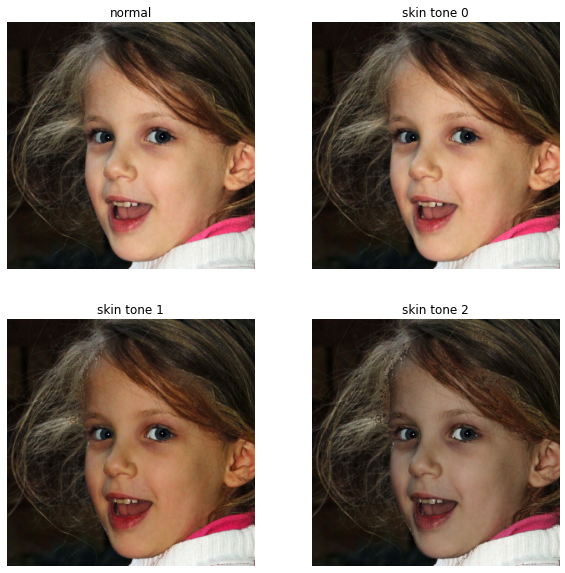

In [147]:
i = 4
filename = IMAGE_FILES[i]
image = cv2.imread(filename)

f = plt.figure(figsize=(10, 10), facecolor='white')
ax = f.add_subplot(2,2,1)
ax.imshow(image[:,:,::-1])
ax.set_title('normal')
ax.axis('off')

for i in range(3):
    ax = f.add_subplot(2,2,i+2)
    new_img = change_skin_tone(image, i)
    ax.imshow(new_img[:,:,::-1])
    ax.set_title('skin tone '+str(i))
    ax.axis('off')
f.savefig('skin_tones.png', bbox_inches='tight')
plt.show()

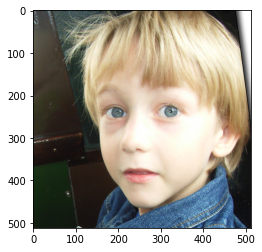

mean: [ 16.456609    74.72646521 205.88821448]
1 / 3


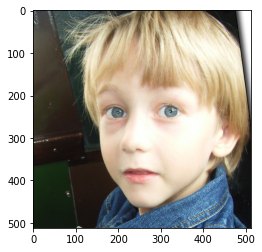

mean: [ 16.456609    74.72646521 205.88821448]
1 / 3


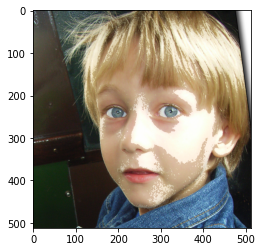

mean: [ 16.456609    74.72646521 205.88821448]
1 / 3


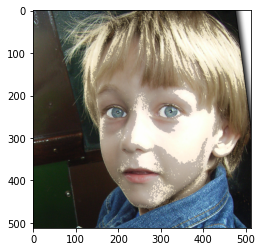

In [148]:
for i in range(1):
    filename = IMAGE_FILES[i]
    image = cv2.imread(filename)
    plt.imshow(image[:,:,::-1])
    plt.show()
    for f in range(3):
        #skin mask
        r = image[:,:,2]
        g = image[:,:,1]
        b = image[:,:,0]
        c1 = r > 95
        c2 = g > 40
        c3 = b > 20
        c4 = (np.max(image, axis=2) - np.min(image, axis=2)) > 15
        c4 = np.abs(r-g) > 15
        c5 = r > g
        c6 = r > b
        skin_mask = c1 & c2 & c3 & c4 & c5 & c6
        #operation
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        xs,ys = np.where(skin_mask)
        mean_skin = np.mean(hsv[xs,ys,:], axis=0)
        print('mean:', mean_skin)
        skins = np.array([
            # [41,17,94],
            [28,37,90],
            # [29,41,92],
            # [29,41,92],
            # [29,45,72],
            [22,68,55],
            # [15,67,41],
            [19,31,31],
            ])
        matching_skin = np.argmin(np.linalg.norm(skins-mean_skin, axis=1))
        print(matching_skin+1, '/', skins.shape[0])
        change = skins[max(0, min(skins.shape[0]-1, f))]-skins[matching_skin]
        hsv[xs,ys,1:] += change[1:].astype(np.uint8)
        hsv[xs,ys,:].clip(0,255)
        new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        plt.imshow(new_img[:,:,::-1])
        plt.show()

